In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import os
from feast import FeatureStore

In [2]:
df0 = pd.read_csv('Paste path from CSV folder for taxi_zone_lookup.csv')
df0.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [3]:
# import the google creds 
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'Enter path of GCPKey'

<>:3: DeprecationWarning: invalid escape sequence '\O'


In [ ]:
from feast import FeatureStore
from google.cloud import bigquery

# 1. Set up Feast and BQ clients
fs = FeatureStore(repo_path="Paste path of the feature repo created...")
bq = bigquery.Client()

# in From enter your table created in BigQuery
entity_keys = bq.query("""
    SELECT trip_id, pickup_ts
    FROM `opportune-baton-464110-c1.VLBA.Taxi_data_features_split`
    WHERE split = 'dev'
""").to_dataframe()

# Fetch historical features for those entities
feature_refs = [
    "taxi_features:pickup_bin",
    "taxi_features:dropoff_bin",
    "taxi_features:trip_time_s",
    "taxi_features:passenger_count",
    "taxi_features:trip_distance",
    "taxi_features:RatecodeID",
    "taxi_features:PULocationID",
    "taxi_features:DOLocationID",
    "taxi_features:total_surcharges",
    "taxi_features:airport_fee",
    "taxi_features:total_amount"
]

df_all = fs.get_historical_features(
    entity_keys,
    feature_refs
).to_df()

print(df_all.head())

In [5]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17051639 entries, 0 to 17051638
Data columns (total 13 columns):
 #   Column            Dtype              
---  ------            -----              
 0   trip_id           object             
 1   pickup_ts         datetime64[us, UTC]
 2   pickup_bin        int64              
 3   dropoff_bin       int64              
 4   trip_time_s       int64              
 5   passenger_count   float64            
 6   trip_distance     float64            
 7   RatecodeID        float64            
 8   PULocationID      int64              
 9   DOLocationID      int64              
 10  total_surcharges  float64            
 11  airport_fee       float64            
 12  total_amount      float64            
dtypes: datetime64[us, UTC](1), float64(6), int64(5), object(1)
memory usage: 1.7+ GB


In [6]:
df_full = df_all[["pickup_bin", "dropoff_bin", "trip_time_s", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "total_surcharges", "airport_fee" , "total_amount"]]
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17051639 entries, 0 to 17051638
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   pickup_bin        int64  
 1   dropoff_bin       int64  
 2   trip_time_s       int64  
 3   passenger_count   float64
 4   trip_distance     float64
 5   RatecodeID        float64
 6   PULocationID      int64  
 7   DOLocationID      int64  
 8   total_surcharges  float64
 9   airport_fee       float64
 10  total_amount      float64
dtypes: float64(6), int64(5)
memory usage: 1.4 GB


In [7]:
df_full.isna().sum()

pickup_bin          0
dropoff_bin         0
trip_time_s         0
passenger_count     0
trip_distance       0
RatecodeID          0
PULocationID        0
DOLocationID        0
total_surcharges    0
airport_fee         0
total_amount        0
dtype: int64

###Exploratory Data Analysis

Steps:
1. Merge - Airport Fee columns
2. Covert attributes 'tpep_pickup_datetime' and 'tpep_dropoff_datetime' to bins and trip_time
3. Encode attribute store_and_fwd_flag
4. Null value treatment: replace with mean
5. Outlier treatment - pending (should be based on full data)

In [9]:
df_full.describe()

,pickup_bin,dropoff_bin,trip_time_s,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,total_surcharges,airport_fee,total_amount
count,1.851800e+07,1.851800e+07,1.851800e+07,1.851800e+07,1.851800e+07,1.851800e+07,1.851800e+07,1.851800e+07,1.851800e+07,1.851800e+07,1.851800e+07
mean,4.189357e+00,4.199660e+00,1.018616e+03,1.329744e+00,4.052219e+00,1.525315e+00,1.656170e+02,1.641799e+02,5.846339e+00,1.213598e-01,2.804910e+01
std,1.428539e+00,1.449040e+00,2.554527e+03,9.040876e-01,2.417019e+02,6.841176e+00,6.405298e+01,6.990931e+01,3.283491e+00,4.212160e-01,9.286096e+01
min,1.000000e+00,1.000000e+00,-2.857500e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-7.680000e+01,-1.750000e+00,-9.829500e+02
25%,3.000000e+00,3.000000e+00,4.480000e+02,1.000000e+00,1.070000e+00,1.000000e+00,1.320000e+02,1.140000e+02,4.000000e+00,0.000000e+00,1.575000e+01
50%,4.000000e+00,4.000000e+00,7.360000e+02,1.000000e+00,1.800000e+00,1.000000e+00,1.620000e+02,1.620000e+02,5.000000e+00,0.000000e+00,2.065000e+01
75%,5.000000e+00,5.000000e+00,1.192000e+03,1.000000e+00,3.420000e+00,1.000000e+00,2.340000e+02,2.340000e+02,6.500000e+00,0.000000e+00,3.010000e+01
max,6.000000e+00,6.000000e+00,6.017510e+05,9.000000e+00,3.423450e+05,9.900000e+01,2.650000e+02,2.650000e+02,6.745600e+02,1.750000e+00,3.869880e+05


In [8]:
# List of 4 attributes to check for outliers
selected_attributes = ['trip_time_s', 'trip_distance', 'RatecodeID', 'total_surcharges',
                       'total_amount']  # replace with your actual column names

# Calculate Q1 and Q3 for the selected attributes
Q1 = df_full[selected_attributes].quantile(0.25)
Q3 = df_full[selected_attributes].quantile(0.75)

# Compute IQR
IQR = Q3 - Q1

# Identify rows that are NOT outliers on any of the selected attributes
non_outlier_mask = ~((df_full[selected_attributes] < (Q1 - 10 * IQR)) |
                     (df_full[selected_attributes] > (Q3 + 10 * IQR))).any(axis=1)

# Apply the mask to the full DataFrame
df_full_treated = df_full[non_outlier_mask]

# Check the new shape
df_full_treated.shape

(16483145, 11)

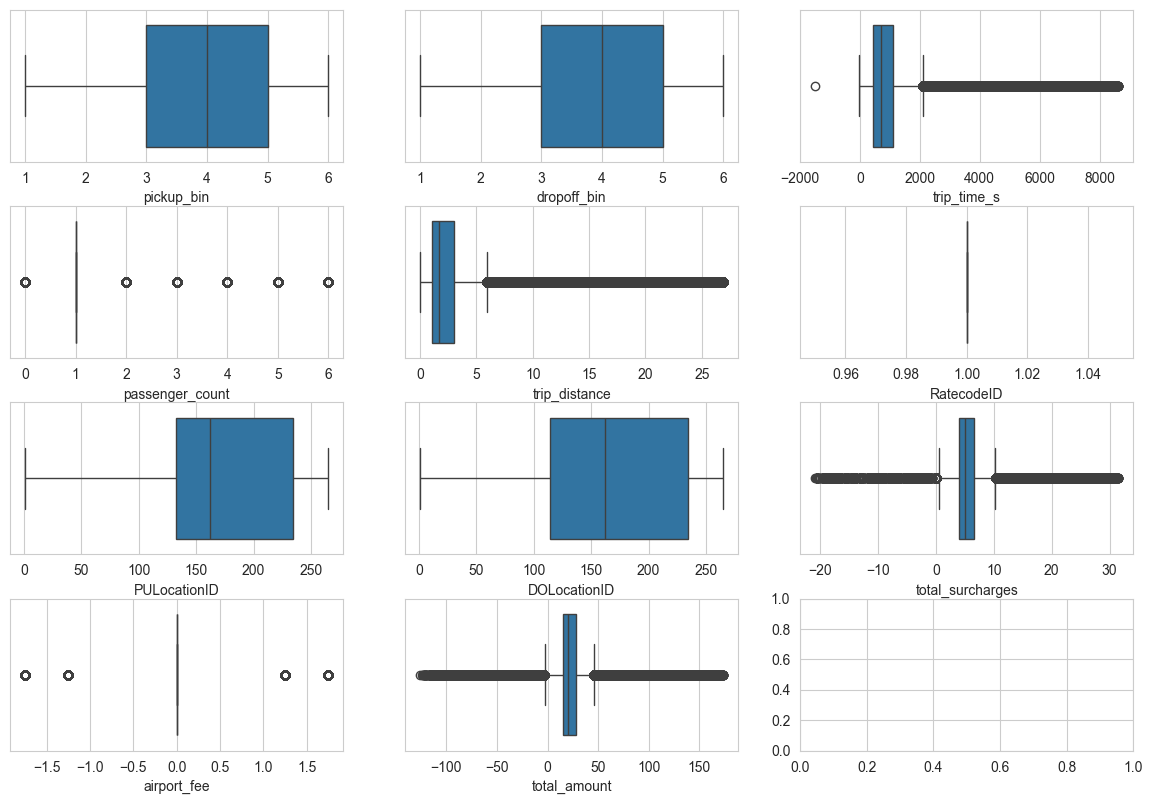

In [11]:
df_num = df_full_treated.select_dtypes(np.number)
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize = (12,8))
plt.tight_layout()
for var, subplot in zip(df_num.columns, ax.flatten()):
    sns.boxplot(x = df_full_treated[var], ax = subplot)
plt.show()

Regression:

1. Dattime columns - pending
2. Scaling - pending
3. Train - Test split
4. Regression
5. Evaluation Metrics
6. Hyperparameter tuning - pending
7. Evaluation - pending

In [9]:
df_full = df_full_treated

In [10]:
from sklearn.model_selection import train_test_split

X = df_full.drop(['total_amount'], axis = 1)
y = df_full['total_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0, test_size = 0.3)

In [11]:
len(X_train), len(X_test), len(y_train), len(y_test)

(11538201, 4944944, 11538201, 4944944)

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12962596 entries, 2658469 to 8325804
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   pickup_bin        float64
 1   dropoff_bin       float64
 2   trip_time_s       float64
 3   passenger_count   float64
 4   trip_distance     float64
 5   RatecodeID        float64
 6   PULocationID      float64
 7   DOLocationID      float64
 8   total_surcharges  float64
 9   airport_fee       float64
dtypes: float64(10)
memory usage: 1.1 GB


In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mlflow.models.signature import infer_signature
from sklearn.model_selection import GridSearchCV

mlflow.set_experiment("Decision Tree Regressor")
mlflow.set_tracking_uri("http://localhost:5000")

param_grid = {"max_depth": [20, 30],"min_samples_split": [10, 50], "min_samples_leaf": [10, 50], "max_leaf_nodes": [500, 1000]}

grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=10), param_grid=param_grid, cv=3, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_
y_hat_train = best_model.predict(X_train)
y_hat_test = best_model.predict(X_test)

# MLflow logging
with mlflow.start_run():

    # Log model
    input_example = pd.DataFrame(X_train[:5], columns=X_train.columns)
    signature = infer_signature(X_train, y_hat_train)

    mlflow.sklearn.log_model(sk_model=best_model,artifact_path="DT_Regressor",input_example=input_example,signature=signature,registered_model_name="DT_Regressor")

    # Log metrics
    mlflow.log_metric("train_r2", r2_score(y_train, y_hat_train))
    mlflow.log_metric("train_rmse", np.sqrt(mean_squared_error(y_train, y_hat_train)))
    mlflow.log_metric("train_mae", mean_absolute_error(y_train, y_hat_train))

    mlflow.log_metric("test_r2", r2_score(y_test, y_hat_test))
    mlflow.log_metric("test_rmse", np.sqrt(mean_squared_error(y_test, y_hat_test)))
    mlflow.log_metric("test_mae", mean_absolute_error(y_test, y_hat_test))

    # Log best hyperparameters
    best_params = best_model.get_params()
    mlflow.log_param("max_depth", best_params["max_depth"])
    mlflow.log_param("min_samples_split", best_params["min_samples_split"])
    mlflow.log_param("min_samples_leaf", best_params["min_samples_leaf"])
    mlflow.log_param("max_leaf_nodes", best_params["max_leaf_nodes"])

print("Model version", result.version, "Model name", result.name)

2025/07/02 00:48:24 INFO mlflow.tracking.fluent: Experiment with name 'Decision Tree Regressor' does not exist. Creating a new experiment.
